# Thyroid Dataset
## Preprocessing

In [1]:
import os

import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, Birch
from sklearn.metrics import completeness_score, homogeneity_score, balanced_accuracy_score, precision_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import operator
from pyomo.environ import *
from pyomo.opt import SolverFactory

In [2]:
SEED = 1234
name = "seeds_data.csv"
DATASET_PATH = os.path.join("datasets", name)
df = pd.read_csv(DATASET_PATH, delimiter=";", header=0)
columns = list(df.columns)
X = df[columns[:-1]]
y = df[columns[-1]]
feature_names = columns[:-1]

In [4]:
print("Number of rows: {}\nShape: {}".format(len(df), df.shape))
print("The are {} columns".format(len(df.columns)))
print("\nDistinct values for 'Classes' column\n{}\n".format(df["Classes"].value_counts()))

Number of rows: 210
Shape: (210, 8)
The are 8 columns

Distinct values for 'Classes' column
1    70
2    70
3    70
Name: Classes, dtype: int64



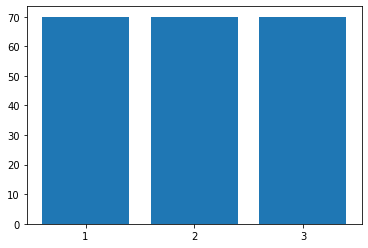

In [5]:
vals = y.unique()
vals.sort()
heights = [len(y[y==x]) for x in vals ]
vals = [str(x) for x in vals]
plt.bar(vals, heights)
plt.show()

In [6]:
X_std = X.copy()
X_std[feature_names] = StandardScaler().fit_transform(X[feature_names])
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.25, random_state=SEED)
classes = y.unique().tolist()
classes.sort() # sorted   

Sample weigthing

In [7]:
occurences = [len(y_train[y_train==x]) for x in classes]
total_samples = sum(occurences)
sample_weight = np.zeros_like(y_train)
for class_index, n_occurr in zip(classes, occurences):
    sample_weight[y_train==class_index]=n_occurr
sample_weight = sample_weight/total_samples

## Clustering

In [8]:
n_leaves = 4
n_clusters = n_leaves
clustering_estimators = []
params = dict(n_clusters=n_clusters, random_state=SEED)
kmeans = KMeans(**params)
clustering_estimators.append(kmeans)

# Spectral clustering not used since it gave looped

params = dict(n_clusters=n_clusters, linkage="single")
agglomerate = AgglomerativeClustering(**params)
clustering_estimators.append(agglomerate)

params = dict(n_clusters=n_clusters, linkage="ward")
agglomerate = AgglomerativeClustering(**params)
clustering_estimators.append(agglomerate)

params = dict(n_clusters=n_clusters, linkage="complete")
agglomerate = AgglomerativeClustering(**params)
clustering_estimators.append(agglomerate)

params = dict(n_clusters=n_clusters, linkage="average")
agglomerate = AgglomerativeClustering(**params)
clustering_estimators.append(agglomerate)

params = dict(n_clusters=n_clusters)
birch = Birch(**params)
clustering_estimators.append(birch)

In [9]:
from src.cluster import find_best_estimator

for i in range(len(clustering_estimators)):
    try:
        clustering_estimators[i] = clustering_estimators[i].fit(X_train, sample_weight=sample_weight.transpose())
    except:
        clustering_estimators[i] = clustering_estimators[i].fit(X_train)

for estimator in clustering_estimators:
    print(estimator.__class__.__name__, homogeneity_score(y_train, estimator.labels_))
    
best_estimator = find_best_estimator(clustering_estimators, homogeneity_score, y_train)
print("The best estimator is {}".format(best_estimator))

KMeans 0.7261283679366535
AgglomerativeClustering 0.01859330194315294
AgglomerativeClustering 0.7986888162083502
AgglomerativeClustering 0.7141741988641893
AgglomerativeClustering 0.7907534575132681
Birch 0.6901918780485845
The best estimator is AgglomerativeClustering(n_clusters=4)


/home/oscarpindaro/miniconda3/envs/decision_trees/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but Birch was fitted with feature names
  warnings.warn(


## Leaves assignment

In [10]:
from src.cluster import best_leaf_assignment
for estimator in clustering_estimators:
    assignment, score = best_leaf_assignment(n_leaves=n_leaves, estimated_labels=estimator.labels_, 
                                      true_labels=y_train, metric=completeness_score)
    print("For the estimator {}, the assignment {} has a score of {}".format(estimator.__class__.__name__,
                                                                             assignment, score))

For the estimator KMeans, the assignment [0, 2, 1, 3] has a score of 0.7595795340741557
For the estimator AgglomerativeClustering, the assignment [0, 2, 1, 3] has a score of 0.1946292848707431
For the estimator AgglomerativeClustering, the assignment [0, 2, 1, 3] has a score of 0.8331515577888864
For the estimator AgglomerativeClustering, the assignment [0, 2, 1, 3] has a score of 0.8331515577888864
For the estimator AgglomerativeClustering, the assignment [0, 1, 2, 3] has a score of 0.7168116778969846
For the estimator Birch, the assignment [0, 2, 1, 3] has a score of 0.8051919914849429


## Parameters Initialization

In [11]:
from src.cluster import HierarchicalLogisticRegression
HLR = HierarchicalLogisticRegression(n_classes=len(np.unique(y_train)), n_leaves=n_leaves, prediction_type="deterministic", random_state=0,
                                     logistic_params={"class_weight": "balanced"})

In [14]:
best = clustering_estimators[0]
best_accuracy = 0
i = 0
for estimator in clustering_estimators:
    """
    print(estimator)
    print(np.unique(estimator.labels_))
    for un in np.unique(estimator.labels_):
        print(len(estimator.labels_[estimator.labels_==un]))
    """
    assignment, score = best_leaf_assignment(n_leaves=n_leaves, estimated_labels=estimator.labels_, 
                                  true_labels=y_train, metric=completeness_score)
    HLR = HLR.fit(X_train.to_numpy(), y_train, cluster_labels=estimator.labels_, leaves_assignment=assignment)
    accuracy = HLR.score(X_test.to_numpy(), y_test)
    print("{} accuracy:{}".format(estimator, accuracy))
    if accuracy > best_accuracy:
        best = clustering_estimators[i]
        best_accuracy = accuracy
    i +=1
print("\nThe best was {} with score {}".format(best, best_accuracy))

KMeans(n_clusters=4, random_state=1234) accuracy:0.5849056603773585
AgglomerativeClustering(linkage='single', n_clusters=4) accuracy:0.03773584905660377
AgglomerativeClustering(n_clusters=4) accuracy:0.03773584905660377
AgglomerativeClustering(linkage='complete', n_clusters=4) accuracy:0.03773584905660377
AgglomerativeClustering(linkage='average', n_clusters=4) accuracy:0.3584905660377358
Birch(n_clusters=4) accuracy:0.03773584905660377

The best was KMeans(n_clusters=4, random_state=1234) with score 0.5849056603773585


In [15]:
assignment, score = best_leaf_assignment(n_leaves=n_leaves, estimated_labels=y_train, 
                                      true_labels=y_train, metric=completeness_score)
print("The true labelling has assignment {} with score {}".format(assignment, score))
HLR = HierarchicalLogisticRegression(n_classes=len(np.unique(y_train)),
                                     n_leaves=n_leaves, prediction_type="deterministic",
                                     random_state=0)
HLR = HLR.fit(X_train.to_numpy(), y_train, cluster_labels=y_train, leaves_assignment=assignment)
accuracy = HLR.score(X_test.to_numpy(), y_test)
print("Accuracy using true labellling: {}".format(accuracy))

The true labelling has assignment [0, 3, 1, 2] with score 1.0000000000000009
Accuracy using true labellling: 0.5471698113207547


In this notebook there is the only case in which a clustrering algorithm performs better than the true labelling.